In [1]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import statsmodels.api as sm

import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

#### read csv files from kaggle 

In [3]:
df_gemini_price_d = pd.read_csv('datasets/kaggle/BTCUSD_day.csv')
df_gemini_price_1h = pd.read_csv('datasets/kaggle/BTCUSD_1hr.csv')

#### convert columns to datetime

In [4]:
df_gemini_price_d['Date'] = pd.to_datetime(df_gemini_price_d['Date'])
df_gemini_price_1h['Date'] = pd.to_datetime(df_gemini_price_1h['Date'])

#### verify the range of datetime in dataframes

In [5]:
print('------------', 'df_gemini_price_d', '------------')
print(df_gemini_price_d['Date'].max())
print(df_gemini_price_d['Date'].min())
print('------------', 'df_gemini_price_1h', '------------')
print(df_gemini_price_1h['Date'].max())
print(df_gemini_price_1h['Date'].min())

------------ df_gemini_price_d ------------
2020-04-09 00:00:00
2015-10-08 00:00:00
------------ df_gemini_price_1h ------------
2020-04-09 00:00:00
2015-10-08 13:00:00


#### verify the numbers of lines in dataframes

In [6]:
print('------------', 'df_coinmarket_price_d', '------------')
print(df_gemini_price_d.shape[0])
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_gemini_price_1h.shape[0])

------------ df_coinmarket_price_d ------------
1646
------------ df_coinmarket_price_1h ------------
39468


In [13]:
class ARForecast(object):
    
    def __init__(self, df, percentage_train_size, periodicity):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
        self.periodicity = periodicity 
        
    def perform(self):
        
        best_params, train_size, y_train_predict = self.grid_search_model()
                
        array_pred = np.array([])
        
        date_test = self.df[train_size:].index
        count = 0
        
        for current_datetime in date_test:

            pred = self.prediction(best_params = best_params, current_datetime = current_datetime)
            array_pred = np.append(array_pred, pred)
#             print('current_datetime ->', current_datetime)
#             print('pred ->', pred)
#             print('---')
            count += 1
            print(count/len(date_test)*100)
        print('---')

        date_train = self.df[:train_size].index
#         date_train = y_train_predict.index
        y_train = self.df[:train_size]['Close'].values
        
        date_test = self.df[train_size:].index
        y_test = self.df[train_size:]['Close'].values
        
        data_train = {
          'date_train': date_train,
          'y_train': y_train,
#           'y_train_predict': y_train_predict.values
        }

        data_test = {
            'date_test': date_test,
            'y_test': y_test,
            'y_test_predict': array_pred
        }

        df_train = pd.DataFrame(data_train)
        df_test = pd.DataFrame(data_test)

        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_test['y_test'],
                                                                        df_test['y_test_predict'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)

        
        return df_train, df_test
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None

        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_params, current_datetime):
        
        p = best_params['p_order']
        d = best_params['d_order']
        q = best_params['q_order']

        if self.periodicity == '1_day':
            train_datetime = (current_datetime - pd.Timedelta(days = 1))

        if self.periodicity == '1_hour':
            train_datetime = (current_datetime - pd.Timedelta(hours = 1))

        model = sm.tsa.statespace.SARIMAX(self.df[:train_datetime], order = (p, d, q), initialization='approximate_diffuse')
        fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False)
        
        pred = fit_model.predict(start = current_datetime, end = current_datetime)
#         print('train_datetime ->', train_datetime)
#         print('self.df[:train_datetime] ->', self.df[:train_datetime].index[-1])

        #integration
#         if d == 1:
            
#             last_close_price = self.df[:current_datetime].values[-1]
#             pred = last_close_price + pred
            
#         if d == 2:
            
#             last_close_price = self.df[:train_datetime].values[-1]
#             before_last_close_price = self.df[:train_datetime].values[-2]
#             last_close_diff_price = last_close_price - before_last_close_price
#             pred = last_close_price + last_close_diff_price + pred
        
        return pred
        
    def grid_search_model(self):
        
        train_size = int(len(self.df) * self.percentage_train_size)
        
        best_aic = np.inf 
        best_params = None
        best_fit = None

        p_range = range(6)
        d_range = range(3) # [0,1,2]

        for d in d_range:
            for p in p_range:
                try:
                    model = sm.tsa.statespace.SARIMAX(self.df[:train_size], order = (p, d, 0), initialization='approximate_diffuse')
                    fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False)

                    if fit_model.aic < best_aic:
                        
                        best_aic = fit_model.aic
                        best_params = {'p_order': p, 'd_order': d, 'q_order': 0}
                        best_fit = fit_model

                except: continue

        print('AIC', best_aic, 'best_params', best_params)
        
        y_train_predict = best_fit.fittedvalues
        
        return best_params, train_size, y_train_predict

In [17]:
### MAIN

# df = df_gemini_price_d.copy()
df = df_gemini_price_1h.copy()

df = df.set_index('Date')
df = df.sort_values(by = ['Date'])
df = df.loc[:, ['Close']]

df = df.asfreq('H') # D or H

ar_forecast = ARForecast(df = df,
                         percentage_train_size = 0.80,
                         periodicity = '1_hour'
                        )
df_train, df_test = ar_forecast.perform()

AIC 354679.0896206291 best_params {'p_order': 4, 'd_order': 1, 'q_order': 0}
0.01266784899923993
0.02533569799847986
0.03800354699771979
0.05067139599695972
0.06333924499619964
0.07600709399543958
0.0886749429946795
0.10134279199391943
0.11401064099315936
0.12667848999239928
0.1393463389916392
0.15201418799087915
0.16468203699011907
0.177349885989359
0.19001773498859895
0.20268558398783887
0.21535343298707882
0.2280212819863187
0.24068913098555864
0.25335697998479856
0.2660248289840385
0.2786926779832784
0.29136052698251835
0.3040283759817583
0.31669622498099825
0.32936407398023815
0.34203192297947804
0.354699771978718
0.36736762097795794
0.3800354699771979
0.3927033189764378
0.40537116797567774
0.41803901697491763
0.43070686597415764
0.44337471497339753
0.4560425639726374
0.4687104129718774
0.48137826197111727
0.49404611097035717
0.5067139599695971
0.5193818089688371
0.532049657968077
0.5447175069673169
0.5573853559665568
0.5700532049657968
0.5827210539650367
0.5953889029642767
0.6080

5.561185710666329
5.573853559665569
5.586521408664809
5.599189257664048
5.6118571066632885
5.624524955662529
5.637192804661768
5.649860653661008
5.6625285026602485
5.675196351659488
5.687864200658728
5.7005320496579674
5.713199898657208
5.725867747656448
5.738535596655687
5.751203445654928
5.763871294654168
5.776539143653408
5.789206992652648
5.8018748416518875
5.814542690651128
5.827210539650367
5.839878388649607
5.8525462376488475
5.865214086648087
5.877881935647327
5.890549784646567
5.903217633645807
5.915885482645047
5.928553331644286
5.9412211806435264
5.953889029642767
5.966556878642006
5.979224727641246
5.9918925766404865
6.004560425639727
6.017228274638967
6.029896123638206
6.0425639726374465
6.055231821636687
6.067899670635926
6.080567519635166
6.093235368634406
6.105903217633646
6.118571066632886
6.131238915632125
6.143906764631366
6.156574613630605
6.169242462629845
6.181910311629085
6.194578160628325
6.207246009627565
6.219913858626805
6.232581707626045
6.245249556625285
6.

11.287053458322777
11.299721307322017
11.312389156321256
11.325057005320497
11.337724854319736
11.350392703318976
11.363060552318217
11.375728401317456
11.388396250316696
11.401064099315935
11.413731948315176
11.426399797314415
11.439067646313655
11.451735495312896
11.464403344312135
11.477071193311374
11.489739042310616
11.502406891309857
11.515074740309096
11.527742589308335
11.540410438307577
11.553078287306816
11.565746136306055
11.578413985305296
11.591081834304536
11.603749683303775
11.616417532303016
11.629085381302255
11.641753230301495
11.654421079300734
11.667088928299975
11.679756777299215
11.692424626298454
11.705092475297695
11.717760324296934
11.730428173296174
11.743096022295415
11.755763871294654
11.768431720293894
11.781099569293135
11.793767418292374
11.806435267291613
11.819103116290854
11.831770965290094
11.844438814289333
11.857106663288572
11.869774512287814
11.882442361287053
11.895110210286292
11.907778059285533
11.920445908284773
11.933113757284012
11.945781606

16.810235621991385
16.822903470990624
16.835571319989864
16.848239168989107
16.860907017988346
16.873574866987585
16.88624271598683
16.898910564986068
16.911578413985307
16.924246262984546
16.936914111983786
16.949581960983025
16.962249809982268
16.974917658981507
16.987585507980747
17.000253356979986
17.012921205979225
17.025589054978465
17.038256903977704
17.050924752976947
17.063592601976186
17.076260450975425
17.088928299974665
17.101596148973904
17.114263997973143
17.126931846972386
17.139599695971626
17.152267544970865
17.164935393970104
17.177603242969344
17.190271091968583
17.202938940967822
17.215606789967065
17.228274638966305
17.240942487965544
17.253610336964783
17.266278185964023
17.278946034963262
17.291613883962505
17.304281732961744
17.316949581960984
17.329617430960223
17.342285279959462
17.3549531289587
17.36762097795794
17.380288826957184
17.392956675956423
17.405624524955662
17.418292373954902
17.43096022295414
17.44362807195338
17.456295920952623
17.468963769951863

22.396757030656193
22.409424879655436
22.422092728654675
22.434760577653915
22.447428426653154
22.460096275652393
22.472764124651633
22.485431973650876
22.498099822650115
22.510767671649354
22.523435520648594
22.536103369647833
22.548771218647072
22.56143906764631
22.574106916645555
22.586774765644794
22.599442614644033
22.612110463643273
22.624778312642512
22.63744616164175
22.650114010640994
22.662781859640234
22.675449708639473
22.688117557638712
22.70078540663795
22.71345325563719
22.726121104636434
22.738788953635673
22.751456802634912
22.76412465163415
22.77679250063339
22.78946034963263
22.80212819863187
22.814796047631113
22.827463896630352
22.84013174562959
22.85279959462883
22.86546744362807
22.87813529262731
22.890803141626552
22.90347099062579
22.91613883962503
22.92880668862427
22.94147453762351
22.95414238662275
22.966810235621992
22.97947808462123
22.992145933620474
23.004813782619713
23.017481631618953
23.030149480618192
23.04281732961743
23.05548517861667
23.0681530276

27.970610590321765
27.983278439321
27.995946288320244
28.008614137319483
28.021281986318726
28.033949835317962
28.046617684317205
28.05928553331644
28.071953382315684
28.08462123131492
28.097289080314162
28.1099569293134
28.122624778312645
28.13529262731188
28.147960476311123
28.16062832531036
28.173296174309602
28.18596402330884
28.198631872308084
28.21129972130732
28.223967570306563
28.2366354193058
28.24930326830504
28.26197111730428
28.274638966303524
28.28730681530276
28.299974664302002
28.31264251330124
28.32531036230048
28.33797821129972
28.350646060298963
28.3633139092982
28.375981758297442
28.388649607296678
28.40131745629592
28.41398530529516
28.4266531542944
28.43932100329364
28.45198885229288
28.464656701292117
28.47732455029136
28.4899923992906
28.50266024828984
28.51532809728908
28.52799594628832
28.540663795287557
28.5533316442868
28.565999493286036
28.57866734228528
28.59133519128452
28.60400304028376
28.616670889283004
28.62933873828224
28.642006587281482
28.6546744362

33.59513554598429
33.607803394983534
33.62047124398277
33.63313909298201
33.64580694198125
33.65847479098049
33.67114263997973
33.68381048897897
33.69647833797821
33.70914618697745
33.72181403597669
33.73448188497593
33.74714973397517
33.759817582974414
33.77248543197366
33.78515328097289
33.797821129972135
33.81048897897137
33.823156827970614
33.83582467696985
33.84849252596909
33.86116037496833
33.87382822396757
33.88649607296681
33.89916392196605
33.91183177096529
33.924499619964536
33.93716746896377
33.949835317963014
33.96250316696225
33.97517101596149
33.98783886496073
34.00050671395997
34.01317456295921
34.02584241195845
34.038510260957686
34.05117810995693
34.063845958956165
34.07651380795541
34.08918165695465
34.10184950595389
34.11451735495313
34.12718520395237
34.13985305295161
34.15252090195085
34.16518875095009
34.17785659994933
34.190524448948565
34.20319229794781
34.215860146947044
34.22852799594629
34.24119584494553
34.25386369394477
34.26653154294401
34.27919939194325


39.29566759564226
39.3083354446415
39.321003293640736
39.33367114263998
39.346338991639215
39.35900684063846
39.3716746896377
39.38434253863694
39.39701038763618
39.40967823663542
39.42234608563466
39.4350139346339
39.447681783633136
39.46034963263238
39.473017481631615
39.48568533063086
39.498353179630094
39.51102102862934
39.52368887762858
39.53635672662782
39.54902457562706
39.5616924246263
39.57436027362554
39.58702812262478
39.599695971624016
39.61236382062326
39.625031669622494
39.63769951862174
39.65036736762097
39.663035216620216
39.67570306561946
39.6883709146187
39.70103876361794
39.71370661261718
39.726374461616416
39.73904231061566
39.751710159614895
39.76437800861414
39.77704585761337
39.789713706612616
39.80238155561186
39.815049404611095
39.82771725361034
39.840385102609574
39.85305295160882
39.86572080060806
39.8783886496073
39.89105649860654
39.90372434760578
39.91639219660502
39.92906004560426
39.941727894603495
39.95439574360274
39.967063592601974
39.97973144160122
3

44.99619964530023
45.00886749429947
45.02153534329871
45.03420319229795
45.04687104129719
45.05953889029643
45.072206739295666
45.08487458829491
45.097542437294145
45.11021028629339
45.12287813529262
45.135545984291866
45.14821383329111
45.16088168229035
45.17354953128959
45.18621738028883
45.19888522928807
45.21155307828731
45.224220927286545
45.23688877628579
45.249556625285024
45.26222447428427
45.2748923232835
45.287560172282745
45.30022802128199
45.31289587028123
45.32556371928047
45.33823156827971
45.350899417278946
45.36356726627819
45.376235115277424
45.38890296427667
45.4015708132759
45.414238662275146
45.42690651127438
45.439574360273625
45.45224220927287
45.4649100582721
45.477577907271346
45.49024575627059
45.502913605269825
45.51558145426907
45.5282493032683
45.540917152267546
45.55358500126678
45.566252850266025
45.57892069926526
45.591588548264504
45.60425639726374
45.61692424626298
45.629592095262225
45.64225994426147
45.654927793260704
45.66759564225995
45.680263491259

50.70939954395743
50.722067392956674
50.73473524195592
50.74740309095516
50.760070939954396
50.77273878895363
50.78540663795288
50.79807448695212
50.81074233595135
50.82341018495059
50.83607803394984
50.848745882949075
50.86141373194831
50.874081580947546
50.886749429946796
50.89941727894603
50.912085127945275
50.92475297694451
50.93742082594376
50.950088674943
50.96275652394223
50.97542437294147
50.98809222194072
51.000760070939954
51.01342791993919
51.02609576893844
51.038763617937676
51.05143146693691
51.064099315936154
51.0767671649354
51.08943501393463
51.102102862933876
51.11477071193311
51.12743856093236
51.1401064099316
51.15277425893083
51.16544210793007
51.17810995692932
51.190777805928555
51.20344565492779
51.21611350392703
51.228781352926276
51.24144920192551
51.254117050924755
51.26678489992399
51.27945274892324
51.29212059792248
51.30478844692171
51.31745629592095
51.3301241449202
51.342791993919434
51.35545984291867
51.368127691917906
51.380795540917156
51.39346338991639

56.409931593615404
56.42259944261464
56.43526729161389
56.447935140613126
56.46060298961236
56.4732708386116
56.48593868761085
56.49860653661008
56.511274385609326
56.52394223460856
56.536610083607805
56.54927793260705
56.56194578160628
56.57461363060552
56.58728147960477
56.599949328604005
56.61261717760324
56.62528502660248
56.63795287560173
56.65062072460096
56.6632885736002
56.67595642259944
56.688624271598684
56.70129212059793
56.71395996959716
56.7266278185964
56.73929566759565
56.751963516594884
56.76463136559412
56.777299214593356
56.789967063592606
56.80263491259184
56.81530276159108
56.82797061059032
56.84063845958956
56.8533063085888
56.86597415758804
56.87864200658728
56.89130985558653
56.90397770458576
56.916645553585
56.929313402584235
56.941981251583485
56.95464910058272
56.96731694958196
56.9799847985812
56.99265264758044
57.00532049657968
57.01798834557892
57.03065619457816
57.04332404357741
57.05599189257664
57.06865974157588
57.081327590575114
57.093995439574364
57.1

62.12313149227261
62.13579934127185
62.14846719027109
62.161135039270334
62.17380288826957
62.186470737268806
62.199138586268056
62.21180643526729
62.22447428426653
62.23714213326576
62.24980998226501
62.26247783126425
62.27514568026349
62.287813529262735
62.30048137826197
62.31314922726121
62.32581707626045
62.3384849252597
62.351152774258935
62.36382062325817
62.37648847225741
62.38915632125666
62.40182417025589
62.41449201925513
62.427159868254364
62.439827717253614
62.45249556625285
62.46516341525209
62.47783126425133
62.49049911325058
62.503166962249814
62.51583481124905
62.528502660248286
62.541170509247536
62.55383835824677
62.56650620724601
62.57917405624524
62.59184190524449
62.60450975424373
62.617177603242965
62.62984545224221
62.64251330124145
62.65518115024069
62.66784899923993
62.680516848239165
62.693184697238415
62.70585254623765
62.71852039523689
62.73118824423612
62.74385609323537
62.75652394223461
62.769191791233844
62.78185964023309
62.79452748923233
62.807195338231

67.91233848492526
67.9250063339245
67.93767418292373
67.95034203192299
67.96300988092221
67.97567772992146
67.9883455789207
68.00101342791994
68.01368127691919
68.02634912591841
68.03901697491766
68.0516848239169
68.06435267291614
68.07702052191537
68.08968837091462
68.10235621991386
68.1150240689131
68.12769191791233
68.14035976691157
68.15302761591082
68.16569546491006
68.1783633139093
68.19103116290853
68.20369901190779
68.21636686090702
68.22903470990626
68.24170255890549
68.25437040790474
68.26703825690397
68.27970610590322
68.29237395490246
68.3050418039017
68.31770965290093
68.33037750190017
68.34304535089942
68.35571319989866
68.3683810488979
68.38104889789713
68.39371674689639
68.40638459589562
68.41905244489486
68.43172029389409
68.44438814289335
68.45705599189257
68.46972384089182
68.48239168989106
68.4950595388903
68.50772738788955
68.52039523688877
68.53306308588802
68.54573093488726
68.5583987838865
68.57106663288573
68.58373448188497
68.59640233088422
68.60907017988346
6

73.72688117557638
73.73954902457562
73.75221687357487
73.76488472257411
73.77755257157335
73.79022042057258
73.80288826957184
73.81555611857107
73.82822396757031
73.84089181656954
73.8535596655688
73.86622751456802
73.87889536356727
73.8915632125665
73.90423106156575
73.91689891056498
73.92956675956422
73.94223460856347
73.95490245756271
73.96757030656195
73.98023815556118
73.99290600456042
74.00557385355967
74.01824170255891
74.03090955155814
74.04357740055738
74.05624524955662
74.06891309855587
74.0815809475551
74.09424879655434
74.10691664555358
74.11958449455283
74.13225234355207
74.1449201925513
74.15758804155055
74.17025589054978
74.18292373954903
74.19559158854825
74.20825943754751
74.22092728654674
74.23359513554598
74.24626298454523
74.25893083354447
74.27159868254371
74.28426653154294
74.29693438054218
74.30960222954143
74.32227007854067
74.3349379275399
74.34760577653914
74.36027362553838
74.37294147453763
74.38560932353685
74.3982771725361
74.41094502153534
74.4236128705345

79.54142386622752
79.55409171522675
79.566759564226
79.57942741322523
79.59209526222448
79.60476311122372
79.61743096022296
79.63009880922219
79.64276665822143
79.65543450722068
79.66810235621992
79.68077020521915
79.69343805421839
79.70610590321763
79.71877375221688
79.73144160121612
79.74410945021535
79.7567772992146
79.76944514821383
79.78211299721308
79.7947808462123
79.80744869521156
79.82011654421079
79.83278439321003
79.84545224220926
79.85812009120852
79.87078794020775
79.88345578920699
79.89612363820623
79.90879148720548
79.92145933620472
79.93412718520395
79.94679503420319
79.95946288320243
79.97213073220168
79.9847985812009
79.99746643020015
80.01013427919939
80.02280212819863
80.03546997719788
80.0481378261971
80.06080567519635
80.07347352419559
80.08614137319483
80.09880922219406
80.11147707119332
80.12414492019255
80.13681276919179
80.14948061819102
80.16214846719028
80.1748163161895
80.18748416518875
80.20015201418799
80.21281986318724
80.22548771218648
80.2381555611857


85.35596655687864
85.36863440587788
85.38130225487713
85.39397010387636
85.4066379528756
85.41930580187484
85.43197365087408
85.44464149987331
85.45730934887256
85.4699771978718
85.48264504687104
85.49531289587028
85.50798074486951
85.52064859386877
85.533316442868
85.54598429186724
85.55865214086647
85.57131998986573
85.58398783886496
85.5966556878642
85.60932353686343
85.62199138586269
85.63465923486191
85.64732708386116
85.6599949328604
85.67266278185964
85.68533063085889
85.69799847985811
85.71066632885736
85.7233341778566
85.73600202685584
85.74866987585507
85.76133772485433
85.77400557385356
85.7866734228528
85.79934127185204
85.81200912085129
85.82467696985051
85.83734481884976
85.850012667849
85.86268051684824
85.87534836584749
85.88801621484672
85.90068406384596
85.9133519128452
85.92601976184444
85.93868761084367
85.95135545984292
85.96402330884216
85.9766911578414
85.98935900684064
86.00202685583987
86.01469470483913
86.02736255383836
86.0400304028376
86.05269825183683
86.06

91.18317709652901
91.19584494552825
91.20851279452748
91.22118064352674
91.23384849252596
91.24651634152521
91.25918419052445
91.2718520395237
91.28451988852294
91.29718773752217
91.30985558652141
91.32252343552065
91.3351912845199
91.34785913351912
91.36052698251837
91.37319483151761
91.38586268051685
91.39853052951608
91.41119837851532
91.42386622751457
91.43653407651381
91.44920192551305
91.46186977451228
91.47453762351154
91.48720547251077
91.49987332151001
91.51254117050924
91.5252090195085
91.53787686850772
91.55054471750697
91.56321256650621
91.57588041550545
91.58854826450468
91.60121611350392
91.61388396250317
91.62655181150241
91.63921966050165
91.65188750950088
91.66455535850012
91.67722320749937
91.68989105649861
91.70255890549784
91.71522675449708
91.72789460349632
91.74056245249557
91.75323030149481
91.76589815049404
91.7785659994933
91.79123384849252
91.80390169749177
91.816569546491
91.82923739549025
91.84190524448948
91.85457309348872
91.86724094248797
91.8799087914872

97.01038763617937
97.02305548517862
97.03572333417786
97.0483911831771
97.06105903217633
97.07372688117559
97.08639473017482
97.09906257917406
97.11173042817329
97.12439827717255
97.13706612617177
97.14973397517102
97.16240182417025
97.1750696731695
97.18773752216873
97.20040537116797
97.21307322016722
97.22574106916646
97.2384089181657
97.25107676716493
97.26374461616417
97.27641246516342
97.28908031416266
97.30174816316189
97.31441601216113
97.32708386116038
97.33975171015962
97.35241955915885
97.36508740815809
97.37775525715733
97.39042310615658
97.40309095515582
97.41575880415505
97.4284266531543
97.44109450215353
97.45376235115278
97.466430200152
97.47909804915126
97.49176589815049
97.50443374714973
97.51710159614898
97.52976944514822
97.54243729414746
97.55510514314669
97.56777299214593
97.58044084114518
97.59310869014442
97.60577653914365
97.61844438814289
97.63111223714213
97.64378008614138
97.6564479351406
97.66911578413985
97.68178363313909
97.69445148213833
97.70711933113758

In [51]:
# AR 1d
# AIC 18658.27618310015 best_params {'p_order': 5, 'd_order': 1, 'q_order': 0}
# mae 263.8137 mape 3.0618 mse 167332.6198 rmse 409.0631 rmspe 5.441 r2 0.927 pearson 0.9636

In [18]:
# AR 1h
# AIC 354679.0896206291 best_params {'p_order': 4, 'd_order': 1, 'q_order': 0}
# mae 43.8826 mape 0.5047 mse 6864.9984 rmse 82.8553 rmspe 1.0067 r2 0.997 pearson 0.9985

In [19]:
# df_train.tail()
# df_test.head()

# df_train.to_csv('train_ar_1d.csv', sep = "\t", index = False)
# df_test.to_csv('test_ar_1d.csv', sep = "\t", index = False)
# pd.read_csv('train_ar_1d.csv', sep = "\t")
# pd.read_csv('test_ar_1d.csv', sep = "\t")

# df_train.to_csv('train_ar_1h.csv', sep = "\t", index = False)
df_test.to_csv('test_ar_1h.csv', sep = "\t", index = False)
# pd.read_csv('train_ar_1h.csv', sep = "\t")
pd.read_csv('test_ar_1h.csv', sep = "\t")

,date_test,y_test,y_test_predict
0,2019-05-16 03:00:00,8247.34,8318.442610
1,2019-05-16 04:00:00,7983.68,8248.420592
2,2019-05-16 05:00:00,7994.15,7999.068173
3,2019-05-16 06:00:00,8126.34,8008.356702
4,2019-05-16 07:00:00,8010.72,8125.886861
...,...,...,...
7889,2020-04-08 20:00:00,7327.70,7319.702417
7890,2020-04-08 21:00:00,7337.19,7327.571063
7891,2020-04-08 22:00:00,7367.28,7336.323628
7892,2020-04-08 23:00:00,7369.60,7365.218336


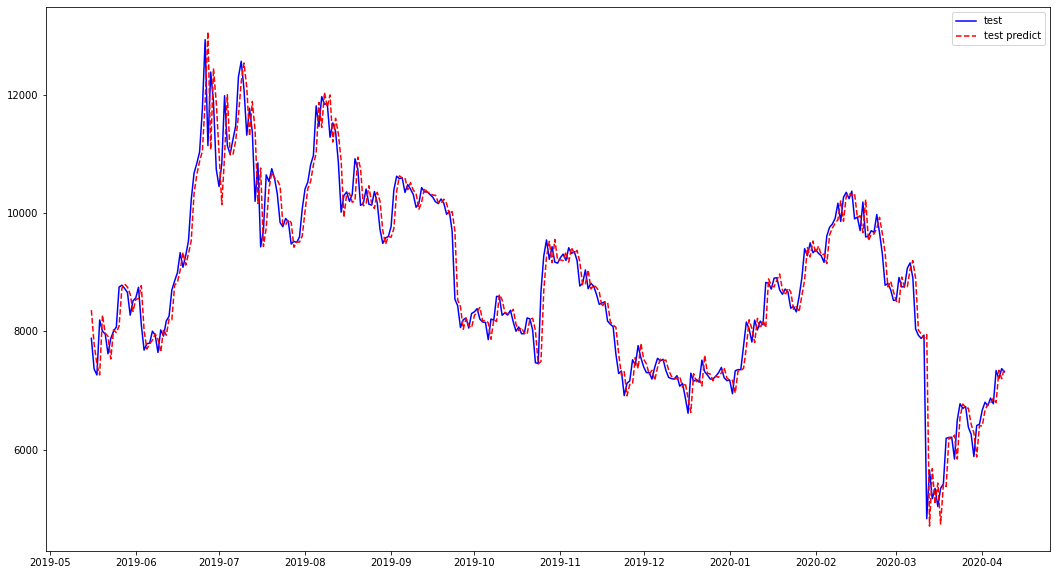

In [16]:
fig, ax = plt.subplots(figsize=(18, 10))

# ax.plot(df_train['date_train'], df_train['y_train'], label = 'train', color="blue")
# ax.plot(df_train['date_train'], df_train['y_train_predict'], '--', label = 'train predict', color="red")

ax.plot(df_test['date_test'], df_test['y_test'], label = 'test', color="blue")
ax.plot(df_test['date_test'], df_test['y_test_predict'], '--', label = 'test predict', color="red")

ax.legend()
plt.show()

In [83]:
a = [2, 4, 16, 32, 64, 128, 256]
data = { 'a': a}
df_a = pd.DataFrame(data)
df_a['diff_1'] = df_a['a'].diff()
df_a['diff_2'] = df_a['diff_1'].diff()
df_a[:5]

,a,diff_1,diff_2
0,2,NaN,NaN
1,4,2.0,NaN
2,16,12.0,10.0
3,32,16.0,4.0
4,64,32.0,16.0


In [85]:
last_close_price = df_a[:5]['a'].values[-1]
before_last_close_price = df_a[:5]['a'].values[-2]
last_close_diff_price = last_close_price - before_last_close_price
pred = last_close_price + last_close_diff_price + df_a[:6]['diff_2'].values[-1]
pred

128.0

In [20]:
df = df_gemini_price_d.copy()
df = df.set_index('Date')
df = df.sort_values(by = ['Date'])
df = df.loc[:, ['Close']]

df = df.asfreq('D') # D or H

model = ARIMA(df[:'2019-04-30'], order=(1, 1, 0))
# print(df[:'2019-04-29'].index[-1])
print(df[:'2019-04-30'].index[-1])
fit_model = model.fit()

pred = fit_model.predict(start = '2019-04-30', end = '2019-04-30', dynamic = False)
pred

2019-04-30 00:00:00


Date
2019-04-30    3.370656
Freq: D, dtype: float64